In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves')

In [ ]:
from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
# importlib.reload(xr)
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
from pathlib import Path
from natsort import natsorted
import matplotlib.pyplot as plt

In [ ]:
from multiprocessing import Pool
import os 
import multiprocessing
from os.path import exists



In [ ]:
sns.set_context("poster")

In [ ]:
def rm_each_month_mean(ds):
    xy_mean = ds["thetao"].mean(dim=['latitude', 'longitude'], skipna=True)
    z_mean = xy_mean.mean(dim = "depth")
    return xy_mean - z_mean
def remove_seasonal(ds):
    climatology = ds.groupby("time.month").mean("time")
    anomalies = ds.groupby("time.month") - climatology
    return anomalies.drop("month")

In [ ]:
%time
from pathlib import Path
from natsort import natsorted
GLORYS_dir = r"/vortexfs1/home/anthony.meza/GLORYS_data" 
results = [str(result) for result in list(Path(GLORYS_dir).rglob("*.[nN][cC]"))] #get all files
results = natsorted(results) #sort all files 

years = natsorted(list(set([result[41:45] for result in results])))
months = natsorted(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 5.01 µs


In [ ]:
#trying to recreate line 90 in California
# y = mx + b 
x0 = -117; y0 = 33
m = ((33 - 31) / (x0 - -125))
b = y0- x0*m 
line = lambda x : m*x + b
xs_C = np.linspace(-125, x0)
ys_C = line(xs_C)

In [ ]:
def read_ds(fname): #very little memory footprint, 1 day = 500kib
    with xr.open_dataset(fname) as ds:
        ds_new = ds[["thetao", "so"]]
        ds_new = ds_new.sel(longitude = slice(-128, -115), latitude = slice(25, 35))
        return ds_new

In [ ]:
# # with xr.open_dataset(results[0]) as ds:
#     print(ds.latitude.min(), ds.latitude.max())
#     print(ds.longitude.min(), ds.longitude.max())

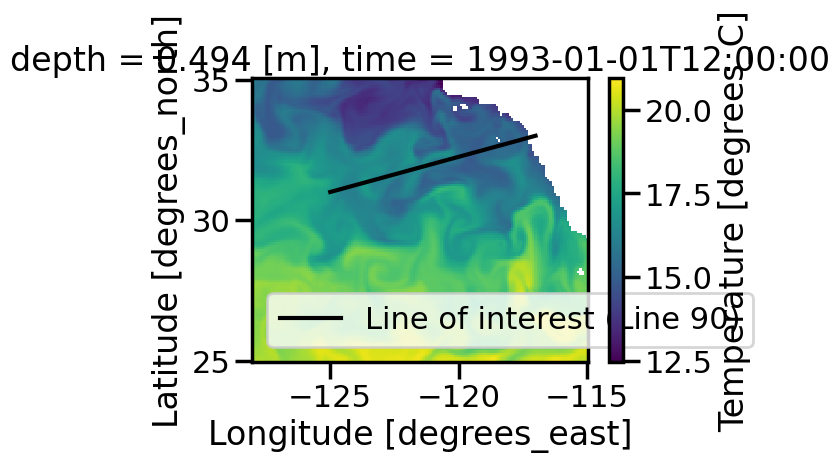

In [ ]:
# %%time Must uses axes when plotting with xarray, else there will be a memory leak 
fig, axes = plt.subplots()
with read_ds(results[0]) as ds:
    LONS, LATS = np.meshgrid(ds.longitude, ds.latitude)
    axes.plot(xs_C, ys_C, color = "black", label = "Line of interest (Line 90)"); 
    ds.thetao.isel(time = 0, depth = 0).plot(ax = axes)
    axes.legend()
    fig.tight_layout()

In [ ]:
with read_ds(results[0]) as ds:
    i_ind, j_ind = get_latlon_idx(ds, xs_C, ys_C)


In [ ]:
#sample along the line 
prev_ind = (np.nan, np.nan)
lons_list = []
lats_list = []
i_ind = []
j_ind = []
tot_dist = []
for (x, y) in zip(xs_C, ys_C): 
    new_ind = where_haversine_min(x, y, LONS, LATS)
    is_unique = new_ind !=prev_ind
    if is_unique:
        i_ind.append(new_ind[0])
        j_ind.append(new_ind[1])
        lons_list.append(LONS[new_ind[0], new_ind[1]])
        lats_list.append(LATS[new_ind[0], new_ind[1]])
        tot_dist.append(haversine_np(lons_list[-1], lats_list[-1], xs_C[-1], ys_C[-1]))
        
    prev_ind = new_ind
#now we have a set of sample pts along a line 

In [ ]:
lat_inds = xr.DataArray(i_ind, dims="points")
lon_inds = xr.DataArray(j_ind, dims="points")
def read_ds_line90(fname): #very little memory footprint, 1 day = 500kib
    with xr.open_dataset(fname) as ds:
        ds_new = ds[["thetao", "so"]]
        ds_new = ds_new.sel(longitude = slice(-128, -115), latitude = slice(25, 35))
        ds_new = ds_new.isel(longitude = lon_inds, latitude = lat_inds)
        ds_new = ds_new.mean(dim=['points'], skipna=True) 
        return ds_new

In [ ]:
%%time 
n_cores = 31
file_not_exist = not(exists("GLORYS_processed/GLORYS_TandS_SoCal_fulldepth.nc"))

CPU times: user 170 µs, sys: 247 µs, total: 417 µs
Wall time: 57.6 ms


In [ ]:
if file_not_exist:
    print("File does not exist, will download data.")
    print("Requires at least 55 GB of RAM and 40 minutes of time")
    CAL_dataset = []
    for year in years:
        print(year)
        files = np.empty(0, dtype = str)
        for month in months:
            file_path = GLORYS_dir + "/" + year + "/" + month
            file_list = natsorted([str(result) for result in list(Path(GLORYS_dir + "/" + year + "/" + month + "/").rglob("*.[nN][cC]"))])
            files = np.concatenate([files, file_list])
        files = natsorted([str(f) for f in files])
        if __name__ == '__main__':
            with Pool(n_cores) as p:
                datasets = p.map(read_ds_line90, files)
        datasets = [d for d in datasets]
        CAL_dataset = CAL_dataset + datasets #about 50 gigs of data!! 


    ds = xr.concat(CAL_dataset, dim = "time", data_vars = "minimal", coords = "minimal")
    ds = ds.sortby("time")
    ds.to_netcdf("GLORYS_processed/GLORYS_TandS_SoCal_fulldepth.nc")
else:
    print("File found, loading file")
    ds = xr.open_dataset("GLORYS_processed/GLORYS_TandS_SoCal_fulldepth.nc")

File found, loading file


In [ ]:
theta_TS = ds.thetao;
salinity_TS = ds.so;

### Get NINO 3.4 Index

In [ ]:
df = pd.read_csv("nino34.long.csv", index_col=0)
dates_df = df.astype("datetime64[D]")
for year in range(0, len(df.index)):
    for month in range(1, len(df.columns)+1):
        dates_df.iloc[year, month - 1] = np.datetime64(pd.Timestamp(df.index[year], month, 15), "D")
NINO34_ds = xr.DataArray(
            data=df.values.flatten(),
            dims=["time"],
            coords=dict(time=dates_df.values.flatten()))
NINO34 = NINO34_ds.sel(time = slice("1993", None))

### Get monthly anomalies from each dset 

In [ ]:
theta_anom = remove_seasonal(theta_TS) #pot. temp anomaly
salinity_anom = remove_seasonal(salinity_TS) #salinity anomaly

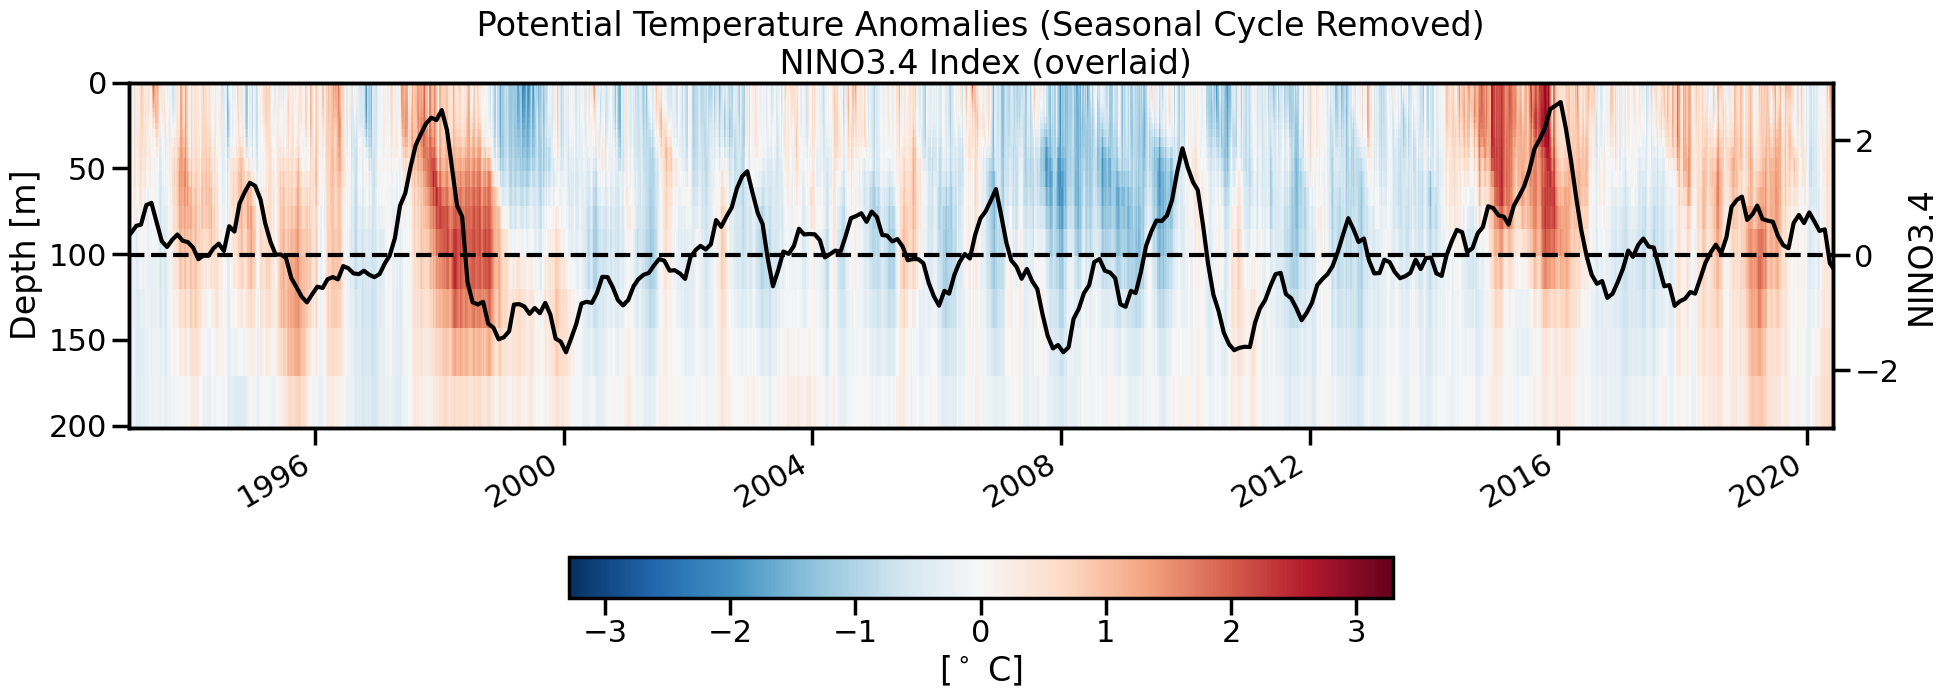

In [57]:
import cmocean.cm as cm 
theta_anom_crop = theta_anom.sel(dict(time = slice(None, "2022"), depth = slice(0, 200))).transpose() #crop
fig, axes = plt.subplots(figsize = (20, 7.5))
theta_anom_crop.plot.pcolormesh(ax=axes, 
                cbar_kwargs={'label' : r"[$^\circ$ C]", 
                             'orientation':"horizontal", 
                             "fraction":0.08, 
                             "pad":0.25
                            })
axes.set_xlabel("")
axes.invert_yaxis()
ax2=axes.twinx()
ax2.hlines(0, axes.get_xlim()[0], axes.get_xlim()[1], linestyle = "--", color = "k")
remove_seasonal(NINO34).plot(ax = ax2, color = "k")
ax2.set_ylabel("NINO3.4",color="black")
ax2.set_ylim(-3, 3)
axes.set_title(" Potential Temperature Anomalies (Seasonal Cycle Removed) \n NINO3.4 Index (overlaid)")
fig.tight_layout();

# fig.savefig("TempAnom.png",  dpi = 400)

### Zoom in on 1996 El Nino 

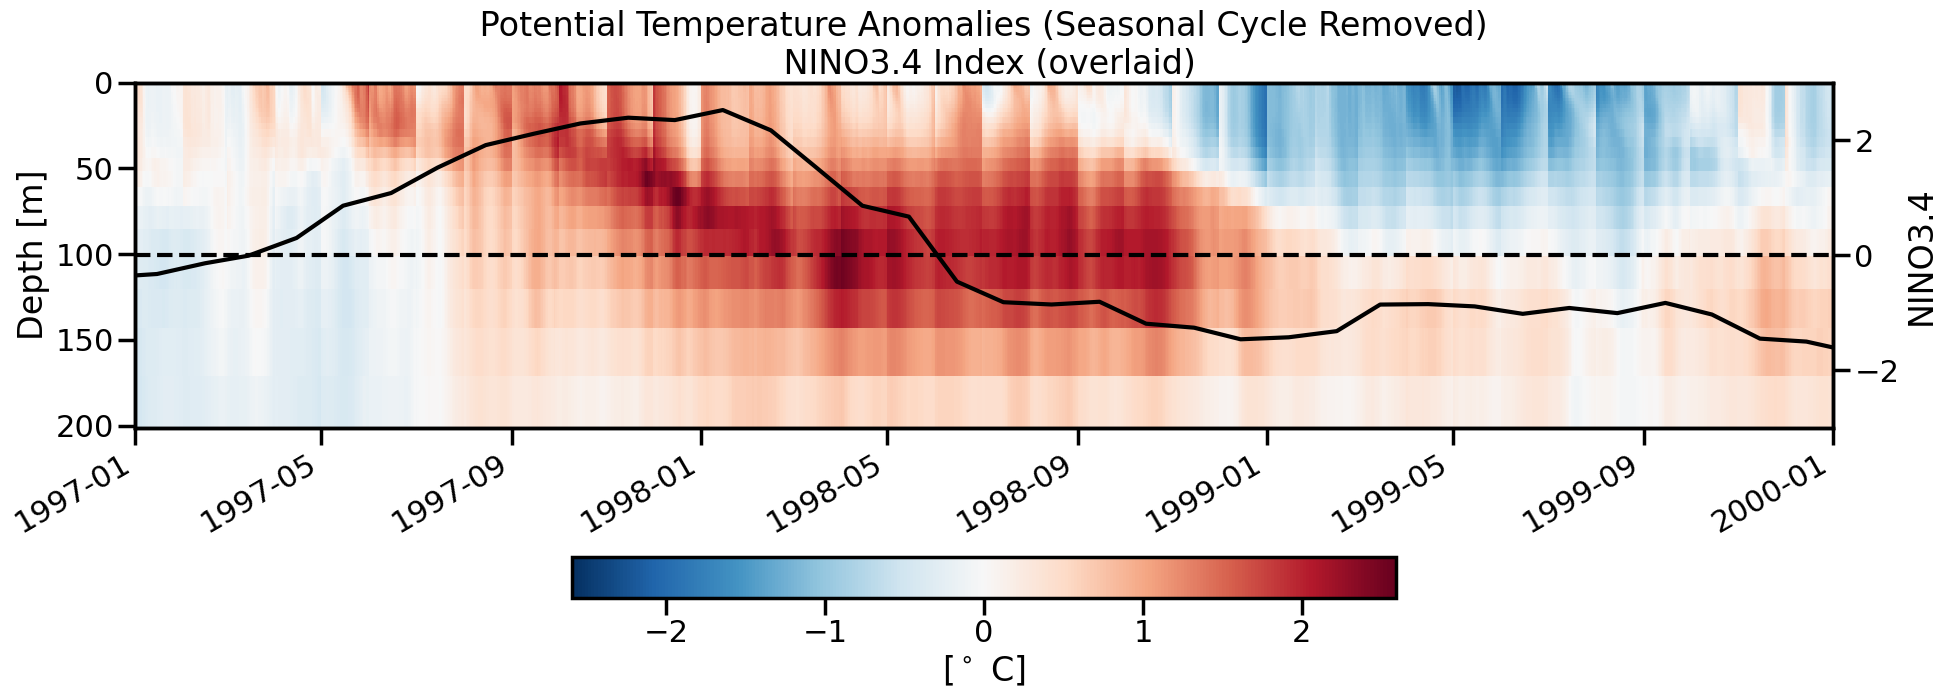

In [64]:
time_slice= slice("1997", "1999")
theta_anom_crop = theta_anom.sel(dict(time = time_slice, depth = slice(0, 200))).transpose() #crop
fig, axes = plt.subplots(figsize = (20, 7.5))
theta_anom_crop.plot.pcolormesh(ax=axes,
                cbar_kwargs={'label' : r"[$^\circ$ C]", 
                             'orientation':"horizontal", 
                             "fraction":0.08, 
                             "pad":0.25})
axes.set_xlabel("")
axes.invert_yaxis()
ax2=axes.twinx()
ax2.hlines(0, axes.get_xlim()[0], axes.get_xlim()[1], linestyle = "--", color = "k")
remove_seasonal(NINO34).plot(ax = ax2, color = "k")
ax2.set_ylabel("NINO3.4",color="black")
ax2.set_ylim(-3, 3)
axes.set_title(" Potential Temperature Anomalies (Seasonal Cycle Removed) \n NINO3.4 Index (overlaid)")

fig.tight_layout();

# fig.savefig("TempAnom_97.png", dpi = 400)


## Focusing on the 1997 El Nino 

### Doing an EOF on this time period, see if a wave pattern appears along coastline around the time of 97 Nino event. EOF will be done on the 100m temperature 

In [69]:
def read_ds_ocn(fname): #very little memory footprint, 1 day = 500kib
    with xr.open_dataset(fname) as ds:
        ds_new = ds[["thetao", "so"]].sel(depth = 102, method = "nearest")
        ds_new = ds_new.sel(longitude = slice(-128, -115), latitude = slice(26, 35))
        return ds_new

In [70]:
%%time 

n_cores = multiprocessing.cpu_count() - 5

NINO_97 = []
for year in ["1997", "1998", "1999", "2000"]:
    print(year)
    files = np.empty(0, dtype = str)
    for month in months:
        file_path = GLORYS_dir + "/" + year + "/" + month
        file_list = natsorted([str(result) for result in list(Path(GLORYS_dir + "/" + year + "/" + month + "/").rglob("*.[nN][cC]"))])
        files = np.concatenate([files, file_list])
    files = natsorted([str(f) for f in files])
    if __name__ == '__main__':
        with Pool(n_cores) as p:
            datasets = p.map(read_ds_ocn, files)
    datasets = [d.drop("depth") for d in datasets]
    NINO_97 = NINO_97 + datasets #about 50 gigs of data!! 
    


1997
1998
1999
2000
CPU times: user 782 ms, sys: 2.04 s, total: 2.82 s
Wall time: 4.53 s


## Acquire the de-seasoned Glorys Tempearture 

In [79]:
%%time 
NINO_97_ds = xr.concat(NINO_97, dim = "time", data_vars = "minimal", coords = "minimal")
NINO_97_ds = NINO_97_ds.sortby("time")

CPU times: user 3.13 s, sys: 846 ms, total: 3.98 s
Wall time: 1min 25s


In [81]:
GLORYS_ds_climatology = read_ds_ocn("GLORYS_processed/GLORYS_Monthly_Data.nc")
GLORYS_ds_climatology = GLORYS_ds_climatology.thetao.groupby("time.month").mean("time")
anomalies = NINO_97_ds.thetao.groupby("time.month") - GLORYS_ds_climatology
NINO_97_ds_anom = anomalies.drop("month")

In [124]:
t_dim, r_dim, c_dim =NINO_97_ds_anom.shape
t_dim, r_dim, c_dim

(1463, 109, 157)

Text(0, 0.5, '%')

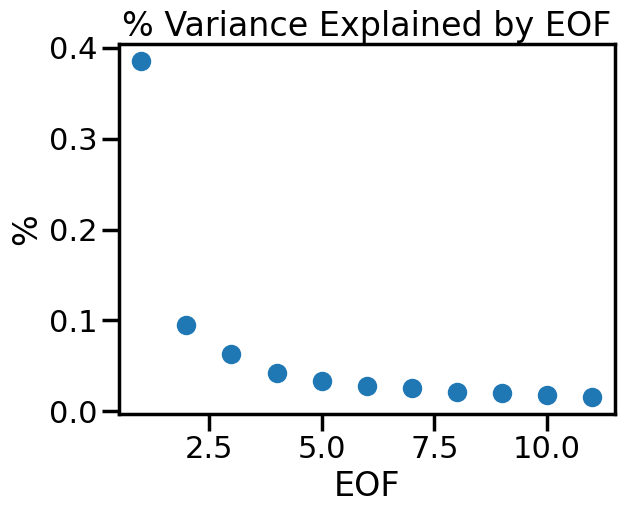

In [130]:
Y, SVD_mat, theta_mean, not_wet = do_EOF_on_xarray(NINO_97_ds_anom.values)
u, s, vh = SVD_mat
perc_var = ([lam**2 / np.sum(s**2) for lam in s[0:11]])
plt.scatter(range(1, len(perc_var)+1), perc_var)
plt.title("% Variance Explained by EOF")
plt.xlabel("EOF")
plt.ylabel("%")

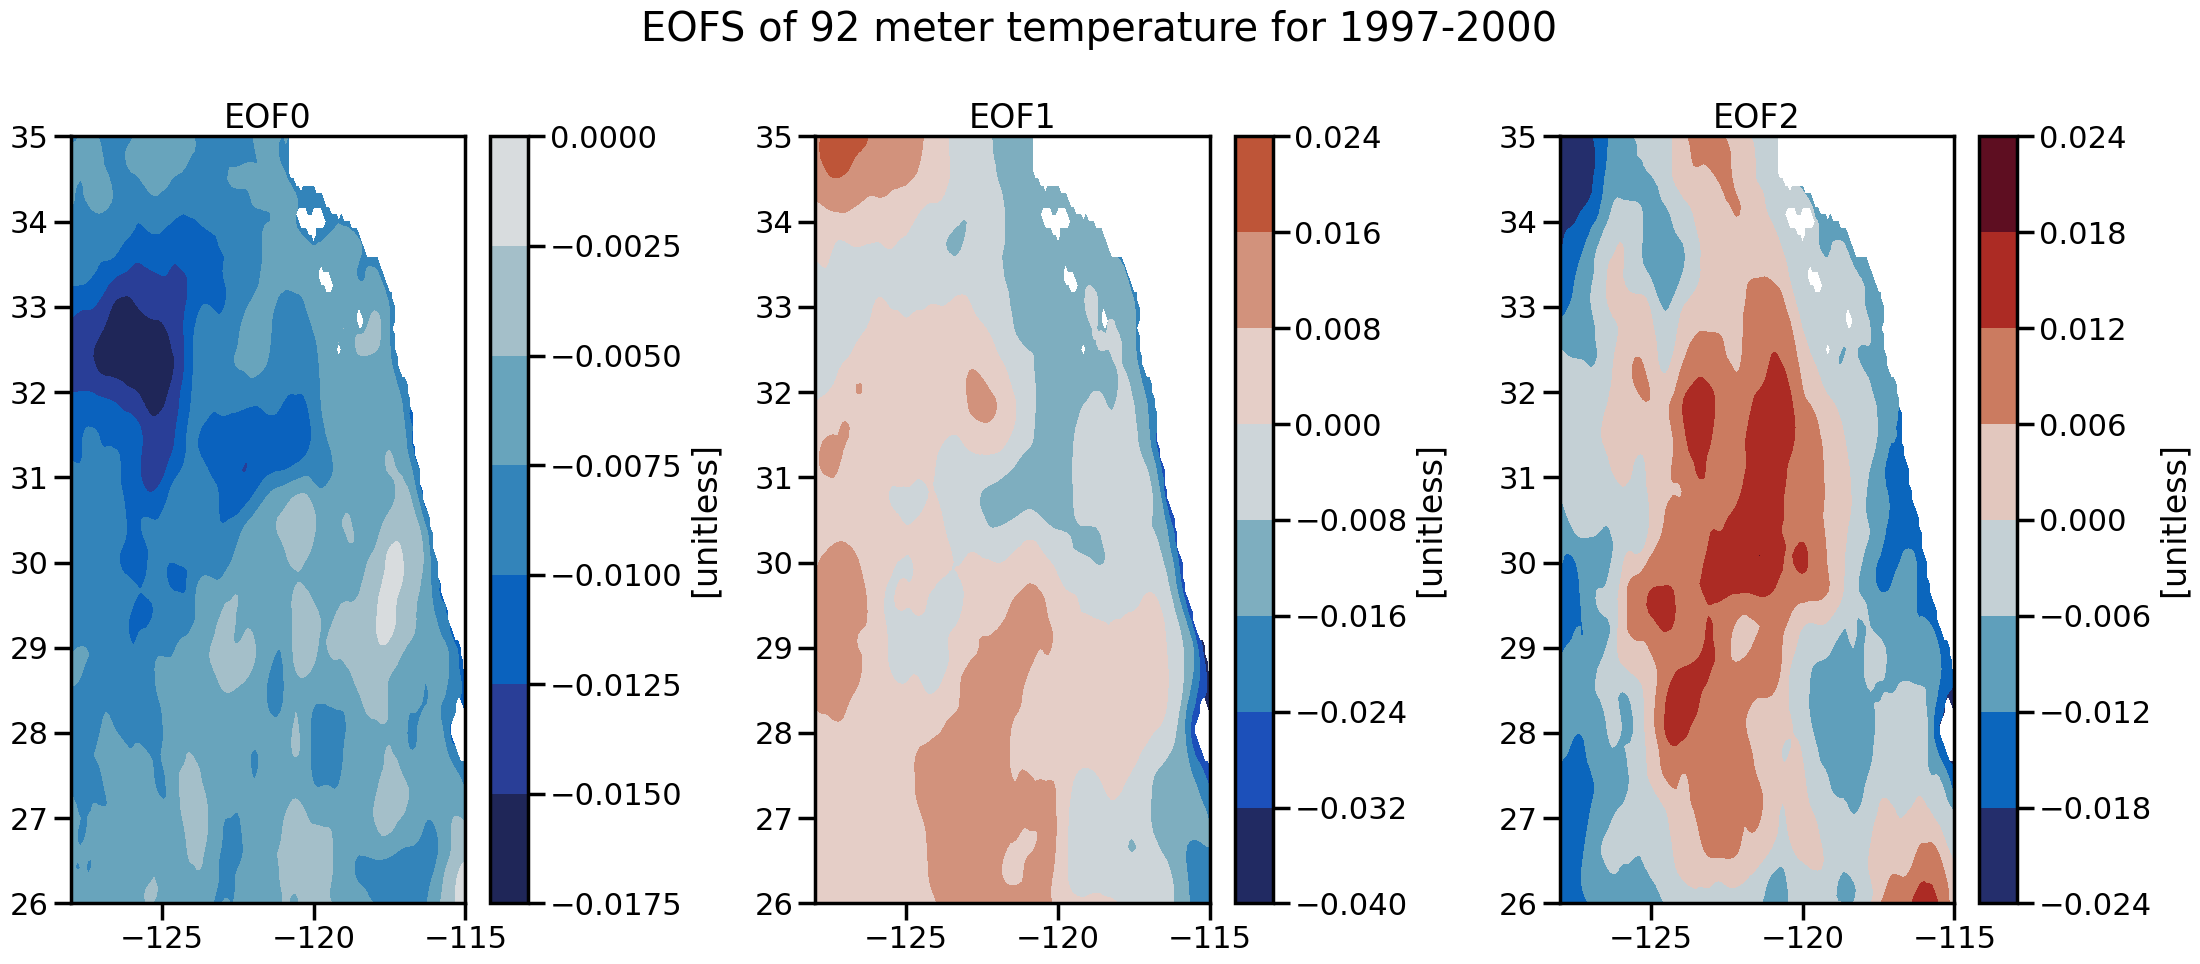

In [140]:
import cmocean
cmap = cmocean.cm.balance

neofs = 3
fig,axes = plt.subplots(ncols= 3, figsize = (22.5, 10))
LONS, LATS = np.meshgrid(NINO_97_ds_anom.longitude, NINO_97_ds_anom.latitude)
ax = axes.flatten()
for i in range(0, neofs):
    
    EOF = np.copy(u[:, i:i+1])
    EOF[not_wet] = np.nan
    EOF = np.reshape(EOF, (r_dim, c_dim))


    bounds = np.nanmax(np.abs(EOF))
    cf = ax[i].contourf(LONS, LATS, EOF, cmap = cmap, vmin = -bounds, vmax = bounds)
    cbar = fig.colorbar(cf, label = "[unitless]", ax = ax[i])
    ax[i].set_title("EOF" + str(i))

fig.suptitle("EOFS of 92 meter temperature for 1997-2000")
fig.tight_layout()

## Acquire the de-seasoned ERA5 Water Vapour 

### Do some re-gridding and daily averaging

In [105]:
def read_ds_atm(fname): #very little memory footprint, 1 day = 500kib
    with xr.open_dataset(fname) as ds:
        ds_new = ds.sel(longitude = slice(-128, -115), latitude = slice(35, 26))
        return ds_new

In [115]:
%%time 
n_cores = multiprocessing.cpu_count() - 5

NINO_97_ERA5 = []
files = np.empty(0, dtype = str)

for year in ["1997", "1998", "1999", "2000"]:
    print(year)
    file_path = ["ERA5_data/ERA5_" + year +".nc"]
    # file_list = natsorted([str(result) for result in list(Path(file_path).rglob("*.[nN][cC]"))])
    files = np.concatenate([files, file_path])
    
files = natsorted([str(f) for f in files])

if __name__ == '__main__':
    with Pool(n_cores) as p:
        datasets = p.map(read_ds_atm, files)
NINO_97_ERA5 = NINO_97_ERA5 + datasets #about 50 gigs of data!! 

#read in data 
NINO_97_ERA5_ds = xr.concat(NINO_97_ERA5, dim = "time", data_vars = "minimal", coords = "minimal")
NINO_97_ERA5_ds = NINO_97_ERA5_ds.sortby("time")

1997
1998
1999
2000
CPU times: user 676 ms, sys: 1.03 s, total: 1.7 s
Wall time: 1.75 s


In [116]:
#resample to daily 
NINO_97_ERA5_ds = NINO_97_ERA5_ds.resample(time="1D").mean()

In [119]:
#construct monthly climatology
ERA5_ds_climatology = read_ds_atm("ERA5_data/ERA5_monthly.nc")
ERA5_ds_climatology = ERA5_ds_climatology.groupby("time.month").mean("time")
anomalies = NINO_97_ERA5_ds.groupby("time.month") - GLORYS_ds_climatology
NINO_97_ERA5_ds_anom = anomalies.drop("month")

In [ ]:
#regridding 
#https://xesmf.readthedocs.io/en/latest/notebooks/Dataset.html
ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(16, 75, 1.0)),
        "lon": (["lon"], np.arange(200, 330, 1.5)),
    }
)

regridder = xe.Regridder(ds, ds_out, "bilinear")
ds_out = regridder(ds)
ds_out

In [148]:
#resampling to daily 
t_dim, r_dim, c_dim =NINO_97_ds_ERA5_anom.tp.shape
t_dim, r_dim, c_dim

(48, 41, 53)